In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.special import factorial
from thewalrus.quantum import click_cumulant

In [2]:
def partition(collection):
    if len(collection) == 1:
        yield [ collection ]
        return

    first = collection[0]
    for smaller in partition(collection[1:]):
        # insert `first` in each of the subpartition's subsets
        for n, subset in enumerate(smaller):
            yield smaller[:n] + [[ first ] + subset]  + smaller[n+1:]
        # put `first` in its own subset 
        yield [ [ first ] ] + smaller

def get_correlation_ideal(V, n_cor = 3, L = 10 ** 4):
    M = len(V) // 2 
    
    first_order = [] 
    for mode in combinations(np.arange(M), 1):
        first_order.append(click_cumulant(np.zeros(2 * M), V, mode)) 
        
    second_order = [] 
    for mode in combinations(np.arange(M), 2):
        second_order.append(click_cumulant(np.zeros(2 * M), V, mode)) 

    if n_cor == 2:
        return first_order, second_order        
        
    third_order = [] 
    for seed in range(L):
        np.random.seed(seed + 1) 
        mode = np.sort(np.random.choice(np.arange(M), 3, replace = False))
        third_order.append(click_cumulant(np.zeros(2 * M), V, mode)) 

    return first_order, second_order, third_order

def get_correlation_sample(sample, n_cor = 3, L = 10 ** 4):
    M = sample.shape[1] 
    
    first_order = [] 
    for mode in combinations(np.arange(M), 1):
        first_order.append(np.average(np.all(sample[:, mode], axis = 1))) 
        
    second_order = [] 
    for mode in combinations(np.arange(M), 2):
        second_order.append(click_cumulant_sample(sample[:, mode])) 
        
    if n_cor == 2:
        return first_order, second_order        
        
    third_order = [] 
    np.random.seed(1) 
    for _ in range(L):
        mode = np.sort(np.random.choice(np.arange(M), 3, replace = False))
        third_order.append(click_cumulant_sample(sample[:, mode])) 

    return first_order, second_order, third_order

def click_cumulant_sample(sample):
    modes = list(range(sample.shape[1])) 
    kappa = 0 
    for pi in partition(modes):
        size = len(pi)
        term = factorial(size - 1) * (-1) ** (size - 1)
        for B in pi:
            B = list(set(B))  # remove repetitions
            summand = np.average(np.all(sample[:, B], axis = 1)) 
            term *= summand
        kappa += term

    return kappa

# Photon click correlation

In [3]:
dir = "<replace/with/your/own/file/directory>"
cov = np.load(dir + "cov.npy")
M = len(cov) // 2

In [18]:
%%time
ideal_cor = get_correlation_ideal(cov, n_cor = 2)
first_order = np.real(ideal_cor[0])
second_order = np.real(ideal_cor[1])
#third_order = np.real(ideal_cor[2])

CPU times: user 7.88 s, sys: 9.02 ms, total: 7.89 s
Wall time: 7.91 s


In [11]:
d = 4; chi = 1000;
samples_MPS = np.load("<replace_with_your_MPS_samples.npy>") 
samples_exp = np.load("<replace_with_experimental_samples.npy>") 

In [15]:
MPS_cor = get_correlation_sample(samples_MPS, n_cor = 2, L = 10 ** 4) 
# n_cor is the order of correlation up to 3rd. And from 3rd, we sample L number of three modes for which we compute the correlation
first_order_MPS = np.real(MPS_cor[0])
second_order_MPS = np.real(MPS_cor[1])
#third_order_MPS = np.real(MPS_cor[2])

In [16]:
exp_cor = get_correlation_sample(samples_exp, n_cor = 2)
first_order_exp = np.real(exp_cor[0])
second_order_exp = np.real(exp_cor[1])
#third_order_exp = np.real(exp_cor[2])

In [17]:
# Pearson correlation
np.corrcoef(second_order, second_order_exp)[0, 1], np.corrcoef(second_order, second_order_MPS)[0, 1]

((0.018264187972604314-2.2753004717495404e-18j),
 (0.036260181483675206-1.6036075573113282e-18j))

In [18]:
# Two-norm
np.linalg.norm(second_order - second_order_exp), np.linalg.norm(second_order - second_order_MPS)

(0.00726239703942427, 0.0050680199575781305)

In [17]:
x1, y1 = np.polyfit(second_order, second_order_exp, 1)
x2, y2 = np.polyfit(second_order, second_order_MPS, 1)

In [18]:
# slope
x1, x2

(0.9431676195205885, 0.9432784034131044)

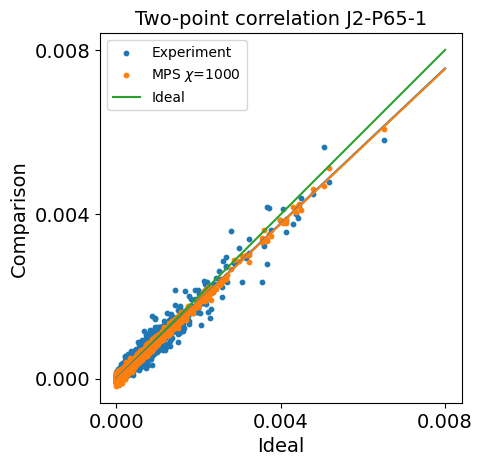

In [19]:
t = np.linspace(0, 0.008, 10);
plt.scatter(second_order, second_order_exp, label = "Experiment", s = 10)
plt.scatter(second_order, second_order_MPS, label = f"MPS $\chi$={chi}", s = 10)
plt.plot(t, t, color = 'C2', label = "Ideal")
plt.plot(t, x1 * t + y1, color = 'C0')
plt.plot(t, x2 * t + y2, color = 'C1')
plt.title("Two-point correlation J2-P65-1", fontsize = 14)
plt.xlabel("Ideal", fontsize = 14)
plt.ylabel("Comparison", fontsize = 14)
plt.xticks(np.linspace(0, 0.008, 3), fontsize = 14)
plt.yticks(np.linspace(0, 0.008, 3), fontsize = 14)
plt.legend(fontsize = 12)
plt.gca().set_aspect('equal')
plt.legend()